In [ ]:
# info: https://cienciadedatos.net/documentos/py10b-regresion-lineal-multiple-python
# Librerías
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.eval_measures import rmse
from scipy import stats
from sklearn.model_selection import train_test_split
from typing import Union

In [ ]:
# Descarga de datos
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/'
    'Estadistica-machine-learning-python/master/data/state_x77.csv'
)
datos = pd.read_csv(url, sep=',')
display(datos.info())
datos.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   habitantes      50 non-null     int64  
 1   ingresos        50 non-null     int64  
 2   analfabetismo   50 non-null     float64
 3   esp_vida        50 non-null     float64
 4   asesinatos      50 non-null     float64
 5   universitarios  50 non-null     float64
 6   heladas         50 non-null     int64  
 7   area            50 non-null     int64  
 8   densidad_pobl   50 non-null     float64
dtypes: float64(5), int64(4)
memory usage: 3.6 KB


None

,habitantes,ingresos,analfabetismo,esp_vida,asesinatos,universitarios,heladas,area,densidad_pobl
0,3615,3624,2.1,69.05,15.1,41.3,20,50708,71.290526
1,365,6315,1.5,69.31,11.3,66.7,152,566432,0.644384
2,2212,4530,1.8,70.55,7.8,58.1,15,113417,19.503249


In [ ]:
# División de los datos en train y test
# ==============================================================================
X = datos.drop(columns='esp_vida')
y = datos['esp_vida']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [ ]:
# Correlación lineal entre variables numéricas
# ==============================================================================
corr_matrix = datos.corr(method='pearson')
tril = np.tril(np.ones(corr_matrix.shape)).astype(bool)
corr_matrix[tril] = np.nan
corr_matrix_tidy = corr_matrix.stack().reset_index(name='r')
corr_matrix_tidy = corr_matrix_tidy.rename(columns={'level_0': 'variable_1', 'level_1': 'variable_2'})
corr_matrix_tidy = corr_matrix_tidy.dropna()
corr_matrix_tidy['r_abs'] = corr_matrix_tidy['r'].abs()
corr_matrix_tidy = corr_matrix_tidy.sort_values('r_abs', ascending=False).reset_index(drop=True)
corr_matrix_tidy

,variable_1,variable_2,r,r_abs
0,esp_vida,asesinatos,-0.780846,0.780846
1,analfabetismo,asesinatos,0.702975,0.702975
2,analfabetismo,heladas,-0.671947,0.671947
3,analfabetismo,universitarios,-0.657189,0.657189
4,ingresos,universitarios,0.619932,0.619932
5,analfabetismo,esp_vida,-0.588478,0.588478
6,esp_vida,universitarios,0.582216,0.582216
7,asesinatos,heladas,-0.538883,0.538883
8,asesinatos,universitarios,-0.487971,0.487971
9,ingresos,analfabetismo,-0.437075,0.437075


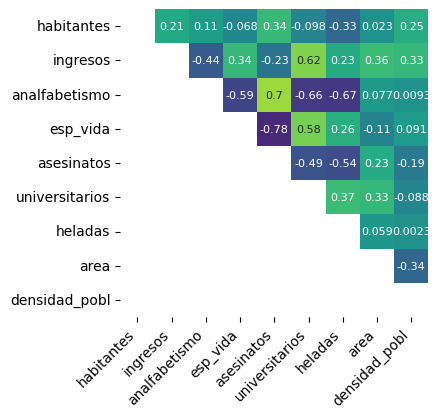

In [ ]:
# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = "viridis",
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)
ax.tick_params(labelsize = 10)

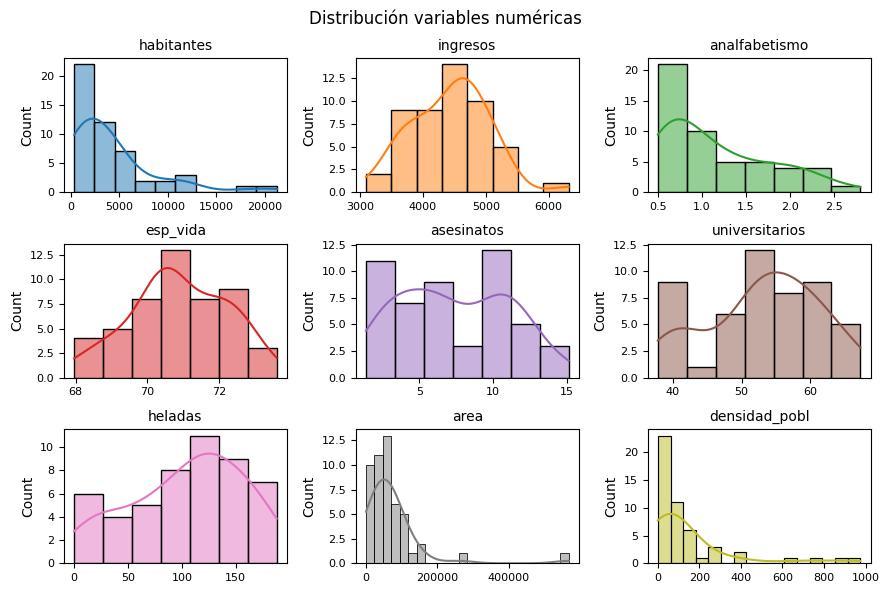

In [ ]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 6))
axes = axes.flat
columnas_numeric = datos.select_dtypes(include=np.number).columns

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = datos,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 10)
    axes[i].tick_params(labelsize = 8)
    axes[i].set_xlabel("")

fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 12);

In [ ]:
# Ajsute del modelo utilizando el modo fórmula (similar a R)
# ==============================================================================
# Para ajustar el modelo utilizando el modo fórmula, es necesario que los datos
# estén almacenados en un único dataframe.
# datos_train = X_train.assign(esp_vida = y_train).copy()
# modelo = smf.ols(
#     formula = 'esp_vida ~ habitantes + ingresos + analfabetismo + asesinatos + universitarios + heladas + area + densidad_pobl',
#     data = datos_train
# )
# modelo_res = modelo.fit()
#print(modelo_res.summary())

In [ ]:
# Ajuste del modelo utilizando matrices X, y (similar a scikit-learn)
# ==============================================================================
# A la matriz de predictores se le tiene que añadir una columna de 1s
# para el intercept del modelo
X_train = sm.add_constant(X_train, prepend=True).rename(columns={'const':'intercept'})
modelo  = sm.OLS(endog=y_train, exog=X_train)
modelo_res = modelo.fit()
print(modelo_res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     12.28
Date:                Sun, 27 Oct 2024   Prob (F-statistic):           1.02e-07
Time:                        21:11:14   Log-Likelihood:                -42.442
No. Observations:                  40   AIC:                             102.9
Df Residuals:                      31   BIC:                             118.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         70.3069      2.171     32.

In [ ]:
# Funciones de selecciçon forward y backward para modelos lineales de statsmodels
# ==============================================================================

def forward_selection(
    X: pd.DataFrame,
    y: pd.Series,
    criterio: str='aic',
    add_constant: bool=True,
    verbose: bool=True
)-> list:

    """
    Realiza un procedimiento de selección de variables hacia adelante (forward)
    utilizando como criterio de bondad la métrica especificada. El procedimiento
    se detiene cuando no es posible mejorar más el modelo añadiendo variables.

    Parameters
    ----------
    X: pd.DataFrame
        Matriz de predictores
    y: pd.Series
        Variable respuesta
    metrica: str, default='aic'
        Métrica utilizada para seleccionar las variables. Debe ser una de las
        siguientes opciones: 'aic', 'bic', 'rsquared_adj'.
    add_constant: bool, default=True
        Si `True` añade una columna de 1s a la matriz de predictores con el
        con el nombre de intercept.
    verbose: bool, default=True
        Si `True` muestra por pantalla los resultados de cada iteración.

    Returns
    -------
    seleccion: list
        Lista con las variables seleccionadas.
    """

    if add_constant:
        X = sm.add_constant(X, prepend=True).rename(columns={'const':'intercept'})

    restantes = X.columns.to_list()
    seleccion = []
    if criterio == 'rsquared_adj':
        mejor_metrica = -np.inf
        ultima_metrica = -np.inf
    else:
        mejor_metrica = np.inf
        ultima_metrica = np.inf

    while restantes:
        metricas = []
        for candidata in restantes:
            seleccion_temp = seleccion + [candidata]
            modelo  = sm.OLS(endog=y, exog=X[seleccion_temp])
            modelo_res = modelo.fit()
            metrica = getattr(modelo_res, criterio)
            metricas.append(metrica)
        if criterio == 'rsquared_adj':
            mejor_metrica = max(metricas)
            if mejor_metrica > ultima_metrica:
                mejor_variable = restantes[np.argmax(metricas)]
            else:
                break
        else:
            mejor_metrica = min(metricas)
            if mejor_metrica < ultima_metrica:
                mejor_variable = restantes[np.argmin(metricas)]
            else:
                break

        seleccion.append(mejor_variable)
        restantes.remove(mejor_variable)
        ultima_metrica = mejor_metrica

        if verbose:
            print(f'variables: {seleccion} | {criterio}: {mejor_metrica:.3f}')

    return sorted(seleccion)


def backward_selection(
    X: pd.DataFrame,
    y: pd.Series,
    criterio: str='aic',
    add_constant: bool=True,
    verbose: bool=True
)-> list:

    """
    Realiza un procedimiento de selección de variables hacia atrás (backward)
    utilizando como criterio de bondad la métrica especificada. El procedimiento
    se detiene cuando no es posible mejorar más el modelo eliminando variables.

    Parameters
    ----------
    X: pd.DataFrame
        Matriz de predictores
    y: pd.Series
        Variable respuesta
    metrica: str, default='aic'
        Métrica utilizada para seleccionar las variables. Debe ser una de las
        siguientes opciones: 'aic', 'bic', 'rsquared_adj'.
    add_constant: bool, default=True
        Si `True` añade una columna de 1s a la matriz de predictores con el
        con el nombre de intercept.
    verbose: bool, default=True
        Si `True` muestra por pantalla los resultados de cada iteración.

    Returns
    -------
    seleccion: list
        Lista con las variables seleccionadas.
    """

    if add_constant:
        X = sm.add_constant(X, prepend=True).rename(columns={'const':'intercept'})

    # Se inicia con todas las variables como predictores
    seleccion = X.columns.to_list()
    modelo  = sm.OLS(endog=y, exog=X[seleccion])
    modelo_res = modelo.fit()
    ultima_metrica = getattr(modelo_res, criterio)
    mejor_metrica = ultima_metrica
    if verbose:
            print(f'variables: {seleccion} | {criterio}: {mejor_metrica:.3f}')

    while seleccion:
        metricas = []
        for candidata in seleccion:
            seleccion_temp = seleccion.copy()
            seleccion_temp.remove(candidata)
            modelo  = sm.OLS(endog=y, exog=X[seleccion_temp])
            modelo_res = modelo.fit()
            metrica = getattr(modelo_res, criterio)
            metricas.append(metrica)
        if criterio == 'rsquared_adj':
            mejor_metrica = max(metricas)
            if mejor_metrica > ultima_metrica:
                peor_variable = seleccion[np.argmax(metricas)]
            else:
                break
        else:
            mejor_metrica = min(metricas)
            if mejor_metrica < ultima_metrica:
                peor_variable = seleccion[np.argmin(metricas)]
            else:
                break

        seleccion.remove(peor_variable)
        ultima_metrica = mejor_metrica

        if verbose:
            print(f'variables: {seleccion} | {criterio}: {mejor_metrica:.3f}')

    return sorted(seleccion)

In [ ]:
# Selección de variables hacia forward
# ==============================================================================
predictores = forward_selection(
    X            = X_train,
    y            = y_train,
    criterio     = 'aic',
    add_constant = False, # Ya se le añadió anteriormente
    verbose      = True
)
predictores

variables: ['intercept'] | aic: 143.990
variables: ['intercept', 'asesinatos'] | aic: 104.951
variables: ['intercept', 'asesinatos', 'universitarios'] | aic: 102.243
variables: ['intercept', 'asesinatos', 'universitarios', 'habitantes'] | aic: 99.607
variables: ['intercept', 'asesinatos', 'universitarios', 'habitantes', 'heladas'] | aic: 97.043


['asesinatos', 'habitantes', 'heladas', 'intercept', 'universitarios']

In [ ]:
predictores= backward_selection(
    X            = X_train,
    y            = y_train,
    criterio     = 'aic',
    add_constant = False, # Ya se le añadió anteriormente
    verbose      = True
)
predictores

variables: ['intercept', 'habitantes', 'ingresos', 'analfabetismo', 'asesinatos', 'universitarios', 'heladas', 'area', 'densidad_pobl'] | aic: 102.884
variables: ['intercept', 'habitantes', 'ingresos', 'asesinatos', 'universitarios', 'heladas', 'area', 'densidad_pobl'] | aic: 101.179
variables: ['intercept', 'habitantes', 'ingresos', 'asesinatos', 'universitarios', 'heladas', 'densidad_pobl'] | aic: 99.295
variables: ['intercept', 'habitantes', 'asesinatos', 'universitarios', 'heladas', 'densidad_pobl'] | aic: 97.549
variables: ['intercept', 'habitantes', 'asesinatos', 'universitarios', 'heladas'] | aic: 97.043


['asesinatos', 'habitantes', 'heladas', 'intercept', 'universitarios']

In [ ]:
# Entrenamiento del modelo con las variables seleccionadas
# ==============================================================================
modelo_final  = sm.OLS(endog=y_train, exog=X_train[predictores])
modelo_final_res = modelo_final.fit()
print(modelo_final_res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     25.81
Date:                Sun, 27 Oct 2024   Prob (F-statistic):           5.11e-10
Time:                        21:12:24   Log-Likelihood:                -43.521
No. Observations:                  40   AIC:                             97.04
Df Residuals:                      35   BIC:                             105.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
asesinatos        -0.3101      0.042     -7.

In [ ]:
# Selección de predictores con sklearn SequentialFeatureSelector
# ==============================================================================
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

modelo = LinearRegression()
sfs = SequentialFeatureSelector(
    modelo,
    n_features_to_select = 'auto',
    direction            = 'forward',
    scoring              = 'r2',
    cv                   = 5
)
sfs.fit(X_train, y_train)
sfs.get_feature_names_out().tolist()

['intercept', 'habitantes', 'asesinatos', 'densidad_pobl']

In [ ]:
# Residuos del modelo
# ==============================================================================
residuos = modelo_final_res.resid

# prediciones de entrenamiento
# ==============================================================================
prediccion_train = modelo_final_res.predict(X_train[predictores])

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


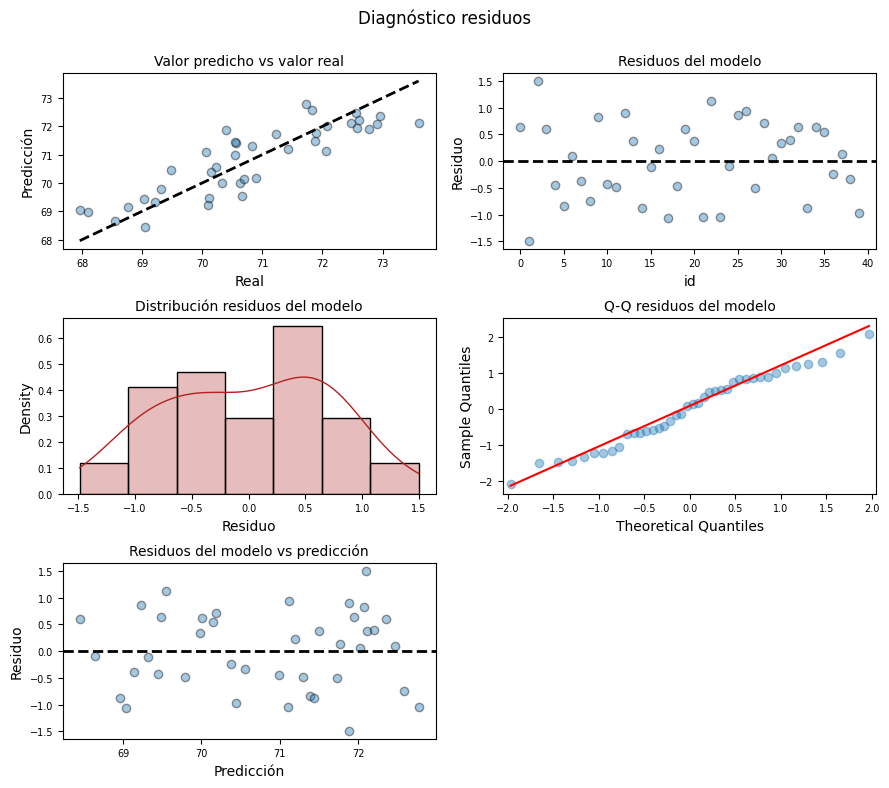

In [ ]:
# Gráficos
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 8))

axes[0, 0].scatter(y_train, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize=10)
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y_train))), residuos, edgecolors=(0, 0, 0), alpha=0.4)
axes[0, 1].axhline(y=0, linestyle='--', color='black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 10)
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuo')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data     = residuos,
    stat     = "density",
    kde      = True,
    line_kws = {'linewidth': 1},
    color    = "firebrick",
    alpha    = 0.3,
    ax       = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize=10)
axes[1, 0].set_xlabel("Residuo")
axes[1, 0].tick_params(labelsize = 7)

sm.qqplot(
    residuos,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1],
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize=10)
axes[1, 1].tick_params(labelsize=7)

axes[2, 0].scatter(prediccion_train, residuos, edgecolors=(0, 0, 0), alpha=0.4)
axes[2, 0].axhline(y=0, linestyle='--', color='black', lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize=10)
axes[2, 0].set_xlabel('Predicción')
axes[2, 0].set_ylabel('Residuo')
axes[2, 0].tick_params(labelsize=7)

# Se eliminan los axes vacíos
fig.delaxes(axes[2,1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize=12);

In [ ]:
# Normalidad de los residuos Shapiro-Wilk test
# ==============================================================================
shapiro_test = stats.shapiro(residuos)
print(f"Test Shapiro-Wilk: estadístico = {shapiro_test[0]}, p-value = {shapiro_test[1]}")

# Normalidad de los residuos D'Agostino's K-squared test
# ==============================================================================
k2, p_value = stats.normaltest(residuos)
print(f"Test D'Agostino's K-squared: estadístico = {k2}, p-value = {p_value}")

Test Shapiro-Wilk: estadístico = 0.9700626181523515, p-value = 0.3615595274049066
Test D'Agostino's K-squared: estadístico = 3.0425718093907816, p-value = 0.21843082505797903


In [ ]:
# Prueba de Breusch-Pagan
# ==============================================================================
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(residuos, X_train[predictores])
print(f"Estadítico= {fvalue}, p-value = {f_p_value}")

Estadítico= 2.3825683928746826, p-value = 0.07014338688009708


In [ ]:
# Correlación entre predictores numéricos
# ==============================================================================
corr_matrix = X_train[predictores].corr(method='pearson')
tril = np.tril(np.ones(corr_matrix.shape)).astype(bool)
corr_matrix[tril] = np.nan
corr_matrix_tidy = corr_matrix.stack().reset_index(name='r')
corr_matrix_tidy = corr_matrix_tidy.rename(columns={'level_0': 'variable_1', 'level_1': 'variable_2'})
corr_matrix_tidy = corr_matrix_tidy.dropna()
corr_matrix_tidy['r_abs'] = corr_matrix_tidy['r'].abs()
corr_matrix_tidy = corr_matrix_tidy.sort_values('r_abs', ascending=False).reset_index(drop=True)
corr_matrix_tidy

,variable_1,variable_2,r,r_abs
0,asesinatos,heladas,-0.549982,0.549982
1,asesinatos,universitarios,-0.517231,0.517231
2,heladas,universitarios,0.448608,0.448608
3,asesinatos,habitantes,0.366638,0.366638
4,habitantes,heladas,-0.228660,0.228660
5,habitantes,universitarios,-0.195857,0.195857


In [ ]:
# Cálculo del VIF
# ==============================================================================
vif = pd.DataFrame()
vif["variables"] = X_train[predictores].columns
vif["VIF"] = [variance_inflation_factor(X_train[predictores].values, i) for i in range(X_train[predictores].shape[1])]
vif

,variables,VIF
0,asesinatos,1.788412
1,habitantes,1.156697
2,heladas,1.515200
3,intercept,78.917401
4,universitarios,1.441241


In [ ]:
# Prediciones del conjunto de test
# ==============================================================================
X_test = sm.add_constant(X_test, prepend=True).rename(columns={'const':'intercept'})
modelo_final_res.predict(X_test[predictores])

,0
37,71.627080
45,70.197194
6,72.102241
44,71.038126
13,70.982884
36,72.470001
8,70.749750
29,71.745882
4,72.255344
49,70.842206


In [ ]:
# Predicciones con intervalo de confianza
# ==============================================================================
# La columna mean contiene la media de la predicción
predicciones = modelo_final_res.get_prediction(exog = X_test[predictores]).summary_frame(alpha=0.05)
predicciones

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
37,71.627080,0.340585,70.935656,72.318503,69.921765,73.332394
45,70.197194,0.144249,69.904353,70.490036,68.611071,71.783317
6,72.102241,0.188786,71.718985,72.485497,70.496964,73.707519
44,71.038126,0.211805,70.608140,71.468113,69.421055,72.655197
13,70.982884,0.143523,70.691516,71.274252,69.397032,72.568735
36,72.470001,0.317495,71.825451,73.114551,70.783148,74.156854
8,70.749750,0.305186,70.130190,71.369310,69.072286,72.427213
29,71.745882,0.214940,71.309531,72.182233,70.127107,73.364657
4,72.255344,0.677814,70.879309,73.631379,70.176041,74.334647
49,70.842206,0.271753,70.290518,71.393894,69.188607,72.495805


In [ ]:
# Predicciones con intervalo de confianza
# ==============================================================================
# La columna mean contiene la media de la predicción
predicciones = modelo_final_res.get_prediction(exog = X_test[predictores]).summary_frame(alpha=0.05)
predicciones

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
37,71.627080,0.340585,70.935656,72.318503,69.921765,73.332394
45,70.197194,0.144249,69.904353,70.490036,68.611071,71.783317
6,72.102241,0.188786,71.718985,72.485497,70.496964,73.707519
44,71.038126,0.211805,70.608140,71.468113,69.421055,72.655197
13,70.982884,0.143523,70.691516,71.274252,69.397032,72.568735
36,72.470001,0.317495,71.825451,73.114551,70.783148,74.156854
8,70.749750,0.305186,70.130190,71.369310,69.072286,72.427213
29,71.745882,0.214940,71.309531,72.182233,70.127107,73.364657
4,72.255344,0.677814,70.879309,73.631379,70.176041,74.334647
49,70.842206,0.271753,70.290518,71.393894,69.188607,72.495805
